# Sex Differences in Functional Gradients - Sex Classification GSP & HCP

## Load packages

In [1]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv
from math import isnan

# Computing
import scipy.io  # loadmat
from scipy import stats
import sklearn 
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import vtk
from IPython.display import display
import matplotlib.collections as clt
import ptitprince as pt

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation
from enigmatoolbox.permutation_testing import spin_test, shuf_test

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'

resdir = '/data/p_02667/sex_diff_gradients/results/'

## Set-up

### Loading the data

In [3]:
## loading demographics information

# GSP
GSP_demographics = pd.read_csv(resdir+'GSP/demographics_cleaned.csv')

# HCP
HCP_demographics = pd.read_csv(resdir+'HCP/merged_demographics_cleaned.csv')



## loading mean gradients

# GSP
GSP_mean_grad = pd.read_csv(resdir+'GSP/mean_gradient_eigenvalues.csv')

# labeling the gradients whereby for GSP: unimodal-heteromodal (G2), visual-sensorimotor (G1)
GSP_mean_grad.columns = ['visual-sensorimotor', 'unimodal-heteromodal', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']


# HCP
HCP_mean_grad = pd.read_csv(resdir+'HCP/mean_gradient_eigenvalues.csv')  

# labeling the gradients whereby for HCP: unimodal-heteromodal (G1), visual-sensorimotor (G2)
HCP_mean_grad.columns = ['unimodal-heteromodal', 'visual-sensorimotor', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']



## loading full gradient arrays

# GSP
GSP_array_aligned_G1 = pd.read_csv(resdir+'GSP/array_aligned_G1.csv')
GSP_array_aligned_G2 = pd.read_csv(resdir+'GSP/array_aligned_G2.csv')
GSP_array_aligned_G3 = pd.read_csv(resdir+'GSP/array_aligned_G3.csv')

# HCP
HCP_array_aligned_G1 = pd.read_csv(resdir+'HCP/array_aligned_G1.csv')
HCP_array_aligned_G2 = pd.read_csv(resdir+'HCP/array_aligned_G2.csv')
HCP_array_aligned_G3 = pd.read_csv(resdir+'HCP/array_aligned_G3.csv')



## loading SLM (model including sex, age and ICV for sex testing for sex differences) containing R results

# GSP
GSP_slm_G1 = pd.read_csv(resdir+'GSP/R_lm_G1_sex_age_icv_res.csv')  # visual - sensorimotor
GSP_slm_G2 = pd.read_csv(resdir+'GSP/R_lm_G2_sex_age_icv_res.csv')  # unimodal - heteromodal
GSP_slm_G3 = pd.read_csv(resdir+'GSP/R_lm_G3_sex_age_icv_res.csv')  

# HCP
HCP_slm_G1 = pd.read_csv(resdir+'HCP/R_lm_G1_sex_age_icv_res.csv')  # unimodal - heteromodal
HCP_slm_G2 = pd.read_csv(resdir+'HCP/R_lm_G2_sex_age_icv_res.csv')  # visual - sensorimotor
HCP_slm_G3 = pd.read_csv(resdir+'HCP/R_lm_G3_sex_age_icv_res.csv')  

### Fetch fsaverage parcellation (coded for Schaefer 400 parcels) - for Spin permutation tests

Spin permutation testing: https://enigma-toolbox.readthedocs.io/en/latest/pages/08.spintest/index.html

In [4]:
# fetch the fsaverage parcellation indicating which schafer parcel (1-400) each of fsaverage5's 20484 vertices belong to
schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400)

### Import the Yeo 7 network coding for the Schaefer 400 parcellation scheme - for plotting by Yeo network (color)

In [5]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN

with open(datadir+'yeo_7.csv') as f:
    reader = csv.reader(f)
    yeo7_networks = list(reader)[0]  # need [0] because the network values are contained in double brackets [[ ]]

In [6]:
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks:
    if i == '1':
        yeo7_networks_array_labels.append('visual')
    elif i == '2':
        yeo7_networks_array_labels.append('sensory motor')
    elif i == '3':
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == '4':
        yeo7_networks_array_labels.append('ventral attention')
    elif i == '5':
        yeo7_networks_array_labels.append('limbic')
    elif i == '6':
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == '7':
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)


# dictionary color palette emphasizing visual, sensory motor, and DMN networks
palette_visual_sensmotor_DMN = {"visual":"tab:cyan",
                                "sensory motor":"tab:orange", 
                                "DMN":"tab:purple",
                                
                                "dorsal attention":"tab:grey",
                                "ventral attention":"tab:grey",
                                "limbic":"tab:grey",
                                "fronto parietal":"tab:grey"}

In [7]:
network_labels = ['visual', 'sensory motor', 'dorsal attention', 'ventral attention', 'limbic', 'fronto parietal', 'DMN']

### Definitions

In [8]:
def print_plot_corr_networks(df1, df2, var, x_label, y_label):
    
    '''
    
    
    Output:
    - correlations between 2 columns of a dataframe, both overall and per network
    - scatterplots colorcoded by yeo network, with regression lines per network
    
    
    '''
    
    # creating a dataframe in order to have the data in the correct format to be plotted
    temp_dict = {x_label: df1[var], y_label: df2[var], 'yeo_network': yeo7_networks_array_labels}  
    dataframe = pd.DataFrame(data = temp_dict)
    

    
    network_labels = ['visual', 'sensory motor', 'dorsal attention', 'ventral attention', 'limbic', 'fronto parietal', 'DMN']

    for i in range(len(network_labels)):
        
        corr_coef = stats.pearsonr(dataframe.loc[dataframe['yeo_network'] == network_labels[i]][x_label], dataframe.loc[dataframe['yeo_network'] == network_labels[i]][y_label])[0]
        p_val = stats.pearsonr(dataframe.loc[dataframe['yeo_network'] == network_labels[i]][x_label], dataframe.loc[dataframe['yeo_network'] == network_labels[i]][y_label])[1]
        
        print(f"{network_labels[i]}: r = {corr_coef}, p = {round(p_val, 3)}")
        
    
    # scatter plot color-coded by network, with regression lines 
    
    sns.lmplot(x = x_label, y = y_label, 
           hue = 'yeo_network',
           data = dataframe,
           ci = False)

    sns.despine()

    plt.title(f'Overall Pearson correlation: r = {round(stats.pearsonr(dataframe[x_label], dataframe[y_label])[0],2)}; p = {round(stats.pearsonr(dataframe[x_label], dataframe[y_label])[1],2)}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

#### other types of plots 

In [9]:
dict_to_plot = {'GSP_G2_t_val': GSP_slm_G2.t_val_sex, 'HCP_G1_t_val': HCP_slm_G1.t_val_sex, 'yeo_network': yeo7_networks_array_labels}
df_tval_sex_diff = pd.DataFrame(data = dict_to_plot)

In [10]:
df_tval_sex_diff

,GSP_G2_t_val,HCP_G1_t_val,yeo_network
0,1.780671,-1.635570,visual
1,0.216289,-4.805591,visual
2,2.305462,2.263515,visual
3,2.286731,2.268279,visual
4,2.985628,2.618321,visual
...,...,...,...
395,-4.240799,-5.380172,DMN
396,-2.923254,-3.316582,DMN
397,-2.323048,-1.077513,DMN
398,-3.617871,-3.277685,DMN


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


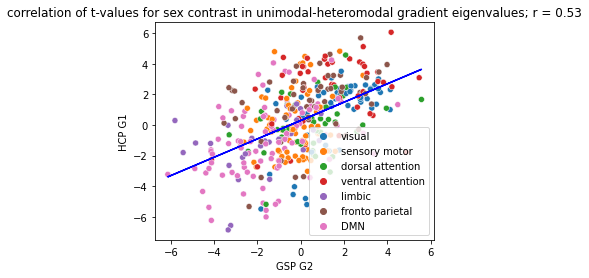

In [11]:
def line(x,y):
    
    """Fit a line in a scatter 
    based on slope and intercept"""
    
    slope, intercept = np.polyfit(x, y, 1)
    line_values = [slope * i + intercept for i in x]
    plt.plot(x, line_values, 'b')


fig, ax = plt.subplots(1, figsize=(5, 4))

sns.scatterplot(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex, 
                hue = yeo7_networks_array_labels)

ax.set_title(f'correlation of t-values for sex contrast in unimodal-heteromodal gradient eigenvalues; r = {round(stats.pearsonr(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)[0],2)}')
ax.set_xlabel('GSP G2')
ax.set_ylabel('HCP G1')
line(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)

## Comparing results between GSP and HCP samples for 3 fc gradients

### Overall

#### Correlation of mean gradients

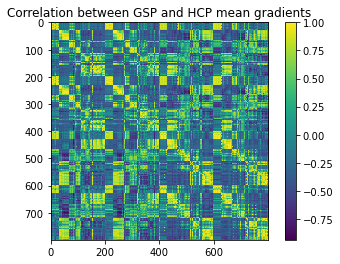

(800, 800)


In [13]:
GSP_HCP_eigenvalues_corr = np.corrcoef(np.array(GSP_mean_grad), np.array(HCP_mean_grad))

# data
fig, ax = plt.subplots()
heatmap = ax.pcolor(GSP_HCP_eigenvalues_corr)
# legend
cbar = plt.colorbar(heatmap)
plt.imshow(np.corrcoef(GSP_HCP_eigenvalues_corr))
plt.title('Correlation between GSP and HCP mean gradients', fontdict=None, loc='center', pad=None)
plt.show()
print(GSP_HCP_eigenvalues_corr.shape)

### Unimodal-Heteromodal

#### Correlation of mean gradient

In [14]:
stats.pearsonr(GSP_mean_grad.loc[:,'unimodal-heteromodal'], HCP_mean_grad.loc[:,'unimodal-heteromodal'])

(0.9090968593615992, 1.9268649390890472e-153)

visual: r = 0.868167367471474, p = 0.0
sensory motor: r = 0.14896103002392624, p = 0.196
dorsal attention: r = 0.22952076778031935, p = 0.125
ventral attention: r = 0.5715658945438941, p = 0.0
limbic: r = 0.8250837958378611, p = 0.0
fronto parietal: r = 0.6379206268147818, p = 0.0
DMN: r = 0.7757328159618283, p = 0.0


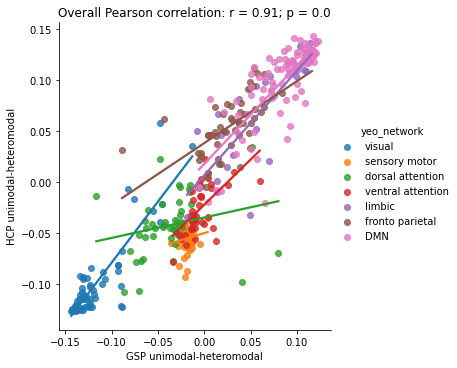

In [15]:
print_plot_corr_networks(df1 = GSP_mean_grad, df2 = HCP_mean_grad, var = 'unimodal-heteromodal', x_label = 'GSP unimodal-heteromodal', y_label = 'HCP unimodal-heteromodal')

Text(0, 0.5, 'HCP G1')

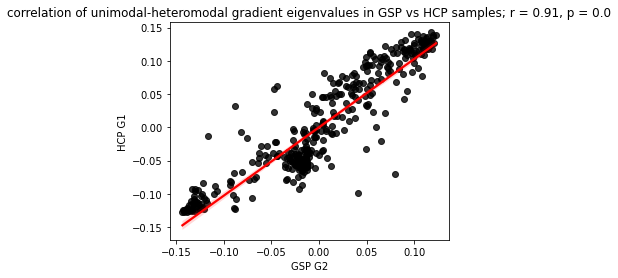

In [16]:
fig, ax = plt.subplots(1, figsize=(5, 4))

sns.regplot(x = GSP_mean_grad.loc[:,'unimodal-heteromodal'], y = HCP_mean_grad.loc[:,'unimodal-heteromodal'],
            scatter_kws={"color": "black"}, line_kws={"color": "red"})

temp_corr = stats.pearsonr(GSP_mean_grad.loc[:,'unimodal-heteromodal'], HCP_mean_grad.loc[:,'unimodal-heteromodal'])

ax.set_title(f'correlation of unimodal-heteromodal gradient eigenvalues in GSP vs HCP samples; r = {round(temp_corr[0],2)}, p = {round(temp_corr[1],3)}')

ax.set_xlabel('GSP G2')
ax.set_ylabel('HCP G1')


#### Spin permutation test (for correlation)

Project unimodal-heteromodal gradient eigenvalues (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices

In [17]:
GSP_fs5_eigenvalues_unimodal_heteromodal = []
HCP_fs5_eigenvalues_unimodal_heteromoda1 = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    #if schaefer_400_fs5[i] == 'nan'
    if schaefer_400_fs5[i] == 0:
        # append to the lists of fs5_tvals: 0
        GSP_fs5_eigenvalues_unimodal_heteromodal.append(0)
        HCP_fs5_eigenvalues_unimodal_heteromoda1.append(0)
        
    # if schaefer_400_fs5 has a value
    else:
        # append to the lists of fs5_tvals: the unimodal-heteromodal gradient eigenvalue of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing)
        GSP_fs5_eigenvalues_unimodal_heteromodal.append(GSP_mean_grad.loc[:, 'unimodal-heteromodal'][schaefer_400_fs5[i]-1])
        HCP_fs5_eigenvalues_unimodal_heteromoda1.append(HCP_mean_grad.loc[:, 'unimodal-heteromodal'][schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
GSP_fs5_eigenvalues_unimodal_heteromodal[GSP_fs5_eigenvalues_unimodal_heteromodal == 0] = np.nan
HCP_fs5_eigenvalues_unimodal_heteromoda1[HCP_fs5_eigenvalues_unimodal_heteromoda1 == 0] = np.nan

# transform list into array
GSP_fs5_eigenvalues_unimodal_heteromodal = np.asarray(GSP_fs5_eigenvalues_unimodal_heteromodal)
HCP_fs5_eigenvalues_unimodal_heteromoda1 = np.asarray(HCP_fs5_eigenvalues_unimodal_heteromoda1)

Spin permutation

In [18]:
# Spin permutation testing for two cortical maps (output of spin_test is the p-value and the null distribution)
spin_test_p, spin_test_d = spin_test(GSP_fs5_eigenvalues_unimodal_heteromodal, HCP_fs5_eigenvalues_unimodal_heteromoda1, surface_name='fsa5', parcellation_name='aparc', type='pearson', n_rot=1000, null_dist=True)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


In [19]:
spin_test_p

0.002

To better interpret statistical significance, we can plot the null distribution of generated correlations (i.e., “spun” or “shuffled” correlations) and overlay the correlation coefficient obtained from the empirical (i.e., real) brain maps.

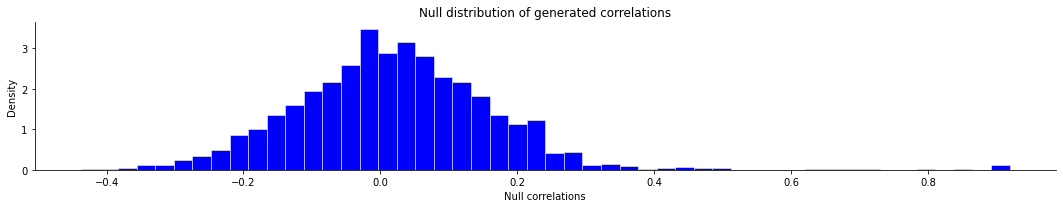

In [20]:
fig, ax = plt.subplots(1, figsize=(15, 3))

ax.hist(spin_test_d, bins=50, density=True, color="blue", edgecolor='white', lw=0.5)
ax.set_xlabel('Null correlations')
ax.set_ylabel('Density')
ax.set_title('Null distribution of generated correlations')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

    
fig.tight_layout()
plt.show()

#### Visualizing gradients by network

RainCloud plots https://github.com/RainCloudPlots/RainCloudPlots#python-environment

RainCloud plot of mean eigenvalues of unimodal-heteromodal gradeitn for 7 Yeo networks - by sample

Mean eigenvalues for aligned unimodal-heteromodal gradient calculated across parcels belonging to each network (all subjects across samples, displayed by sample) 

18074 data points (1014 HCP subjects * 7 networks + 1568 GSP subjects * 7 networks)

In [97]:
# dataframe of the G1 eigenvalues (transposing the original array because we need the 400 parcels to be vertical in the dataframe in order to be labeled with their corresponding Yeo network)
df_GSP_G2 = pd.DataFrame(GSP_array_aligned_G2.T)
df_HCP_G1 = pd.DataFrame(HCP_array_aligned_G1.T)

# adding a column containing the Yeo network labels
df_GSP_G2['yeo network'] = yeo7_networks
df_HCP_G1['yeo network'] = yeo7_networks

# renaming the Yeo network labels
df_GSP_G2.loc[df_GSP_G2["yeo network"] == "1", "yeo network"] = "visual"
df_GSP_G2.loc[df_GSP_G2["yeo network"] == "2", "yeo network"] = "sensory motor"
df_GSP_G2.loc[df_GSP_G2["yeo network"] == "3", "yeo network"] = "dorsal attention"
df_GSP_G2.loc[df_GSP_G2["yeo network"] == "4", "yeo network"] = "ventral attention"
df_GSP_G2.loc[df_GSP_G2["yeo network"] == "5", "yeo network"] = "limbic"
df_GSP_G2.loc[df_GSP_G2["yeo network"] == "6", "yeo network"] = "fronto parietal"
df_GSP_G2.loc[df_GSP_G2["yeo network"] == "7", "yeo network"] = "DMN"

df_HCP_G1.loc[df_HCP_G1["yeo network"] == "1", "yeo network"] = "visual"
df_HCP_G1.loc[df_HCP_G1["yeo network"] == "2", "yeo network"] = "sensory motor"
df_HCP_G1.loc[df_HCP_G1["yeo network"] == "3", "yeo network"] = "dorsal attention"
df_HCP_G1.loc[df_HCP_G1["yeo network"] == "4", "yeo network"] = "ventral attention"
df_HCP_G1.loc[df_HCP_G1["yeo network"] == "5", "yeo network"] = "limbic"
df_HCP_G1.loc[df_HCP_G1["yeo network"] == "6", "yeo network"] = "fronto parietal"
df_HCP_G1.loc[df_HCP_G1["yeo network"] == "7", "yeo network"] = "DMN"

# obtaining the mean of the parcels with the same Yeo network label, then transposing because we need the all subjects to be vertical in the dataframe in order to be labeled with their corresponding sex 
df_GSP_G2 = df_GSP_G2.groupby("yeo network", as_index=True).mean().T
df_HCP_G1 = df_HCP_G1.groupby("yeo network", as_index=True).mean().T

# adding a column containing the label of the respective dataset (for all rows)
df_GSP_G2["sample"] = "GSP"
df_HCP_G1["sample"] = "HCP"

# naming the index and resetting it as an index in order to make it callable in the following melt function
df_GSP_G2.index.name = "sub"
df_GSP_G2 = df_GSP_G2.reset_index()

df_HCP_G1.index.name = "sub"
df_HCP_G1 = df_HCP_G1.reset_index()

# concatenate the two datasets (by index in order to have rows = subjects from both datasets)
df_all_unimodal_heteromodal = pd.concat([df_GSP_G2, df_HCP_G1], axis = 'index')

# for the RainCloud plots, we need dataframe to have all values to be plotted in 1 column, and labels to be plotted in other columns (max 2)
# using melt() to make dataframe long so that mean eigenvalues per network are in one column, whilst preserving the sub number and sample lable as ID variables
df_all_unimodal_heteromodal = pd.melt(df_all_unimodal_heteromodal, id_vars=["sub", 'sample'], var_name='yeo network', value_name='mean unimodal-heteromodal eigenvalues per yeo network')


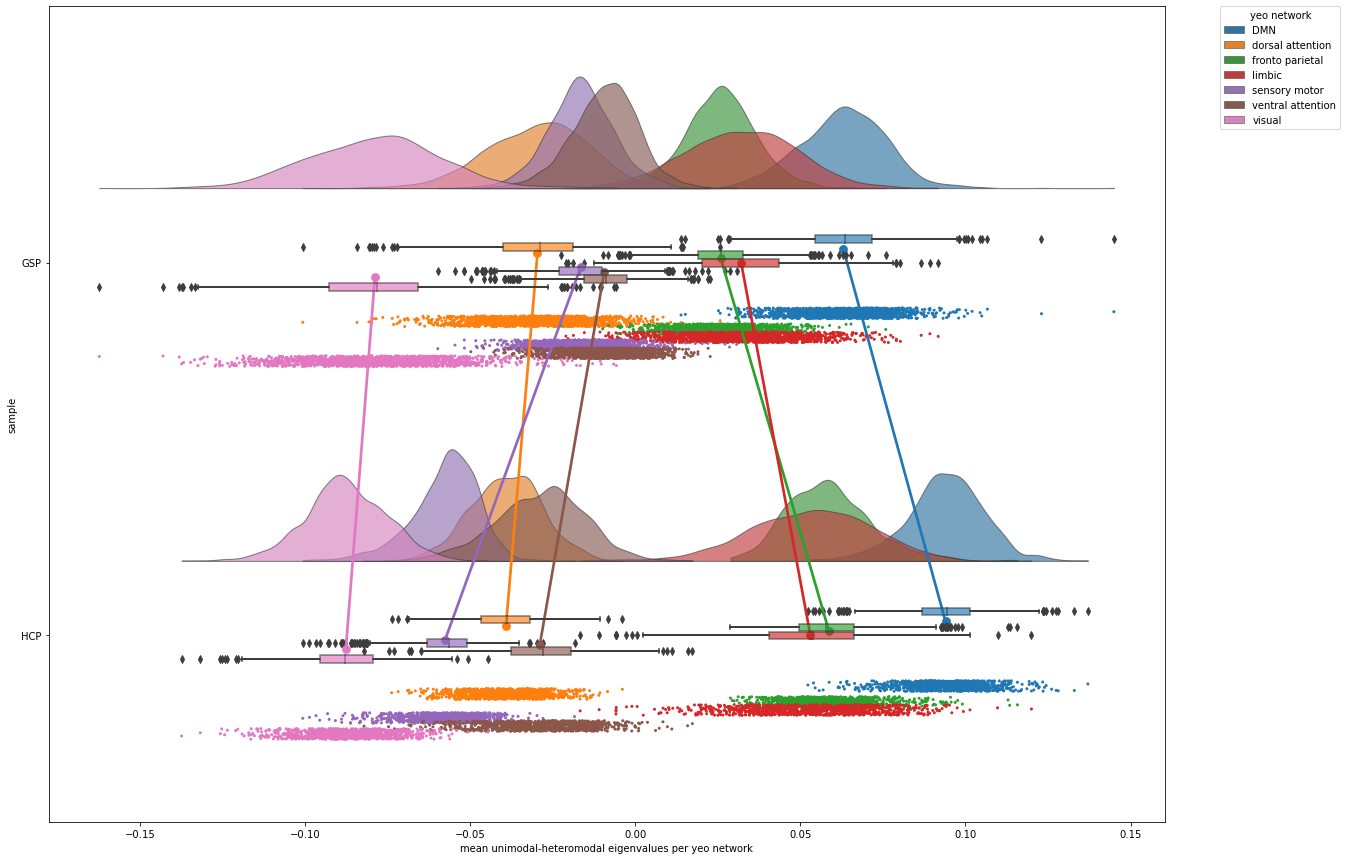

In [98]:
f,ax=plt.subplots(figsize=(20,15))

ax=pt.RainCloud(x="sample",
                y="mean unimodal-heteromodal eigenvalues per yeo network",
                hue="yeo network",
                data=df_all_unimodal_heteromodal,
                palette=sns.color_palette(n_colors=7),
                bw=.2,
                width_viol=.6,
                orient="h",
                move=.2,
                alpha=.65,
                pointplot=True, 
                dodge = True)

### Visual-Sensorimotor

#### Correlation of mean gradient

In [201]:
stats.pearsonr(GSP_mean_grad.loc[:,'visual-sensorimotor'], HCP_mean_grad.loc[:,'visual-sensorimotor'])

(0.9128765076669858, 6.077381262313307e-157)

visual: r = 0.8657777927423497, p = 0.0
sensory motor: r = 0.23902667172902686, p = 0.036
dorsal attention: r = 0.7114429228491049, p = 0.0
ventral attention: r = 0.8042183509406081, p = 0.0
limbic: r = 0.4137828292543885, p = 0.036
fronto parietal: r = 0.5241842305359979, p = 0.0
DMN: r = 0.9273777673590986, p = 0.0


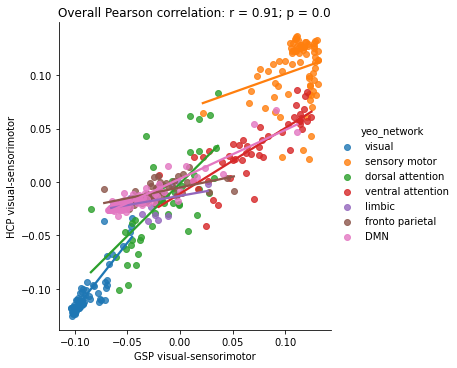

In [200]:
print_plot_corr_networks(df1 = GSP_mean_grad, df2 = HCP_mean_grad, var = 'visual-sensorimotor', x_label = 'GSP visual-sensorimotor', y_label = 'HCP visual-sensorimotor')

Text(0, 0.5, 'HCP G1')

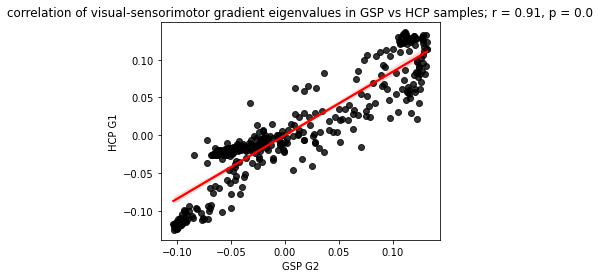

In [202]:
fig, ax = plt.subplots(1, figsize=(5, 4))

sns.regplot(x = GSP_mean_grad.loc[:,'visual-sensorimotor'], y = HCP_mean_grad.loc[:,'visual-sensorimotor'],
            scatter_kws={"color": "black"}, line_kws={"color": "red"})

temp_corr = stats.pearsonr(GSP_mean_grad.loc[:,'visual-sensorimotor'], HCP_mean_grad.loc[:,'visual-sensorimotor'])

ax.set_title(f'correlation of visual-sensorimotor gradient eigenvalues in GSP vs HCP samples; r = {round(temp_corr[0],2)}, p = {round(temp_corr[1],3)}')

ax.set_xlabel('GSP G2')
ax.set_ylabel('HCP G1')


#### Spin permutation test (for correlation)

Project unimodal-heteromodal gradient eigenvalues (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices

In [191]:
GSP_fs5_eigenvalues_visual_sensorimotor = []
HCP_fs5_eigenvalues_visual_sensorimotor = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    #if schaefer_400_fs5[i] == 'nan'
    if schaefer_400_fs5[i] == 0:
        # append to the lists of fs5_tvals: 0
        GSP_fs5_eigenvalues_visual_sensorimotor.append(0)
        HCP_fs5_eigenvalues_visual_sensorimotor.append(0)
        
    # if schaefer_400_fs5 has a value
    else:
        # append to the lists of fs5_tvals: the unimodal-heteromodal gradient eigenvalue of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing)
        GSP_fs5_eigenvalues_visual_sensorimotor.append(GSP_mean_grad.loc[:, 'visual-sensorimotor'][schaefer_400_fs5[i]-1])
        HCP_fs5_eigenvalues_visual_sensorimotor.append(HCP_mean_grad.loc[:, 'visual-sensorimotor'][schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
GSP_fs5_eigenvalues_visual_sensorimotor[GSP_fs5_eigenvalues_visual_sensorimotor == 0] = np.nan
HCP_fs5_eigenvalues_visual_sensorimotor[HCP_fs5_eigenvalues_visual_sensorimotor == 0] = np.nan

# transform list into array
GSP_fs5_eigenvalues_visual_sensorimotor = np.asarray(GSP_fs5_eigenvalues_visual_sensorimotor)
HCP_fs5_eigenvalues_visual_sensorimotor = np.asarray(HCP_fs5_eigenvalues_visual_sensorimotor)

Spin permutation

In [192]:
# Spin permutation testing for two cortical maps (output of spin_test is the p-value and the null distribution)
spin_test_p, spin_test_d = spin_test(GSP_fs5_eigenvalues_visual_sensorimotor, HCP_fs5_eigenvalues_visual_sensorimotor, surface_name='fsa5', parcellation_name='aparc', type='pearson', n_rot=1000, null_dist=True)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


In [193]:
spin_test_p

0.002

To better interpret statistical significance, we can plot the null distribution of generated correlations (i.e., “spun” or “shuffled” correlations) and overlay the correlation coefficient obtained from the empirical (i.e., real) brain maps.

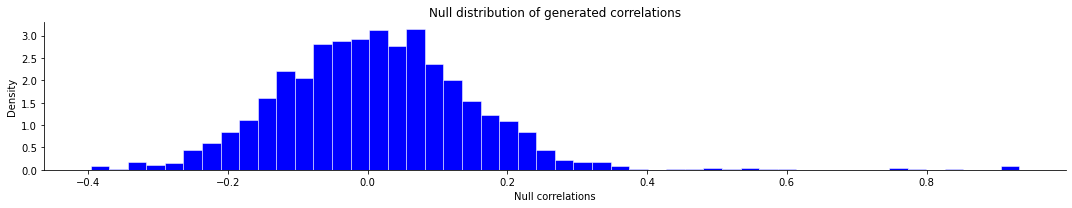

In [194]:
fig, ax = plt.subplots(1, figsize=(15, 3))

ax.hist(spin_test_d, bins=50, density=True, color="blue", edgecolor='white', lw=0.5)
ax.set_xlabel('Null correlations')
ax.set_ylabel('Density')
ax.set_title('Null distribution of generated correlations')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

    
fig.tight_layout()
plt.show()

#### Visualizing gradients by network

RainCloud plots https://github.com/RainCloudPlots/RainCloudPlots#python-environment

RainCloud plot of mean eigenvalues of visual-sensorimotor gradient for 7 Yeo networks - by sample

Mean eigenvalues for aligned visual-sensorimotor gradient calculated across parcels belonging to each network (all subjects across samples, displayed by sample) 

18074 data points (1014 HCP subjects * 7 networks + 1568 GSP subjects * 7 networks)

In [95]:
# dataframe of the G2 eigenvalues (transposing the original array because we need the 400 parcels to be vertical in the dataframe in order to be labeled with their corresponding Yeo network)
df_GSP_G1 = pd.DataFrame(GSP_array_aligned_G1.T)
df_HCP_G2 = pd.DataFrame(HCP_array_aligned_G2.T)

# adding a column containing the Yeo network labels
df_GSP_G1['yeo network'] = yeo7_networks
df_HCP_G2['yeo network'] = yeo7_networks

# renaming the Yeo network labels
df_GSP_G1.loc[df_GSP_G1["yeo network"] == "1", "yeo network"] = "visual"
df_GSP_G1.loc[df_GSP_G1["yeo network"] == "2", "yeo network"] = "sensory motor"
df_GSP_G1.loc[df_GSP_G1["yeo network"] == "3", "yeo network"] = "dorsal attention"
df_GSP_G1.loc[df_GSP_G1["yeo network"] == "4", "yeo network"] = "ventral attention"
df_GSP_G1.loc[df_GSP_G1["yeo network"] == "5", "yeo network"] = "limbic"
df_GSP_G1.loc[df_GSP_G1["yeo network"] == "6", "yeo network"] = "fronto parietal"
df_GSP_G1.loc[df_GSP_G1["yeo network"] == "7", "yeo network"] = "DMN"

df_HCP_G2.loc[df_HCP_G2["yeo network"] == "1", "yeo network"] = "visual"
df_HCP_G2.loc[df_HCP_G2["yeo network"] == "2", "yeo network"] = "sensory motor"
df_HCP_G2.loc[df_HCP_G2["yeo network"] == "3", "yeo network"] = "dorsal attention"
df_HCP_G2.loc[df_HCP_G2["yeo network"] == "4", "yeo network"] = "ventral attention"
df_HCP_G2.loc[df_HCP_G2["yeo network"] == "5", "yeo network"] = "limbic"
df_HCP_G2.loc[df_HCP_G2["yeo network"] == "6", "yeo network"] = "fronto parietal"
df_HCP_G2.loc[df_HCP_G2["yeo network"] == "7", "yeo network"] = "DMN"

# obtaining the mean of the parcels with the same Yeo network label, then transposing because we need the all subjects to be vertical in the dataframe in order to be labeled with their corresponding sex 
df_GSP_G1 = df_GSP_G1.groupby("yeo network", as_index=True).mean().T
df_HCP_G2 = df_HCP_G2.groupby("yeo network", as_index=True).mean().T

# adding a column containing the label of the respective dataset (for all rows)
df_GSP_G1["sample"] = "GSP"
df_HCP_G2["sample"] = "HCP"

# naming the index and resetting it as an index in order to make it callable in the following melt function
df_GSP_G1.index.name = "sub"
df_GSP_G1 = df_GSP_G1.reset_index()

df_HCP_G2.index.name = "sub"
df_HCP_G2 = df_HCP_G2.reset_index()

# concatenate the two datasets (by index in order to have rows = subjects from both datasets)
df_all_visual_sensorimotor = pd.concat([df_GSP_G1, df_HCP_G2], axis = 'index')

# for the RainCloud plots, we need dataframe to have all values to be plotted in 1 column, and labels to be plotted in other columns (max 2)
# using melt() to make dataframe long so that mean eigenvalues per network are in one column, whilst preserving the sub number and sample lable as ID variables
df_all_visual_sensorimotor = pd.melt(df_all_visual_sensorimotor, id_vars=["sub", 'sample'], var_name='yeo network', value_name='mean visual-sensorimotor eigenvalues per yeo network')


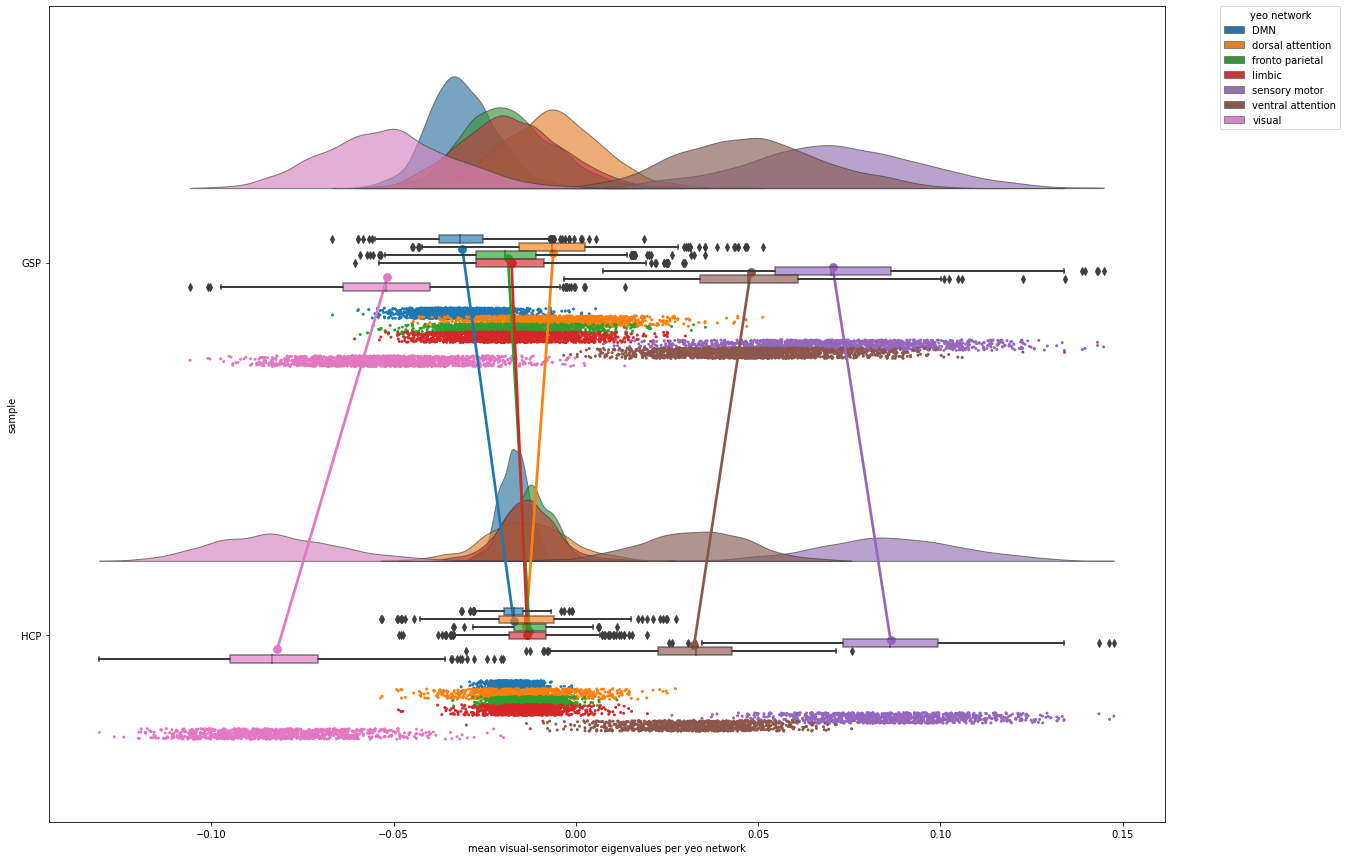

In [96]:
f,ax=plt.subplots(figsize=(20,15))

ax=pt.RainCloud(x="sample",
                y="mean visual-sensorimotor eigenvalues per yeo network",
                hue="yeo network",
                data=df_all_visual_sensorimotor,
                palette=sns.color_palette(n_colors=7),
                bw=.2,
                width_viol=.6,
                orient="h",
                move=.2,
                alpha=.65,
                pointplot=True, 
                dodge = True)

### Sex differences in unimodal-heteromodal gradient

#### Correlation t-values

In [12]:
stats.pearsonr(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)

(0.5254134218266602, 9.105887659757763e-30)

visual: r = 0.5836578759274706, p = 0.0
sensory motor: r = 0.22711531444617436, p = 0.047
dorsal attention: r = 0.3410165439224184, p = 0.02
ventral attention: r = 0.32602707782337803, p = 0.025
limbic: r = 0.377814470078009, p = 0.057
fronto parietal: r = 0.4032537436903269, p = 0.003
DMN: r = 0.43433843486743073, p = 0.0


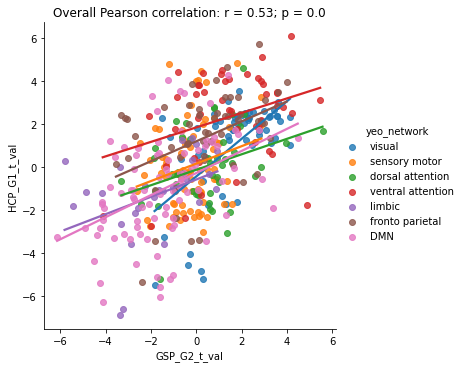

In [13]:
print_plot_corr_networks(df1 = GSP_slm_G2, df2 = HCP_slm_G1, var = 't_val_sex', x_label = 'GSP_G2_t_val', y_label = 'HCP_G1_t_val')

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'HCP G1')

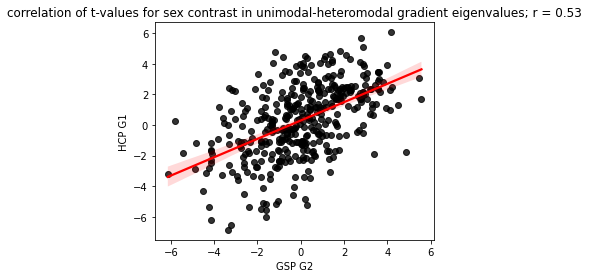

In [14]:
fig, ax = plt.subplots(1, figsize=(5, 4))

sns.regplot(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex,
            scatter_kws={"color": "black"}, line_kws={"color": "red"})

ax.set_title(f'correlation of t-values for sex contrast in unimodal-heteromodal gradient eigenvalues; r = {round(stats.pearsonr(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)[0],2)}')
ax.set_xlabel('GSP G2')
ax.set_ylabel('HCP G1')


#### Spin permutation test (for correlation of t-values)

Project t-values (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices

In [28]:
GSP_fs5_tvals_sexdif_G2 = []
HCP_fs5_tvals_sexdif_G1 = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    #if schaefer_400_fs5[i] == 'nan'
    if schaefer_400_fs5[i] == 0:
        # append to the lists of fs5_tvals: 0
        GSP_fs5_tvals_sexdif_G2.append(0)
        HCP_fs5_tvals_sexdif_G1.append(0)
        
    # if schaefer_400_fs5 has a value
    else:
        # append to the lists of fs5_tvals: the t value of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing t_val_sex)
        GSP_fs5_tvals_sexdif_G2.append(GSP_slm_G2.t_val_sex[schaefer_400_fs5[i]-1])
        HCP_fs5_tvals_sexdif_G1.append(HCP_slm_G1.t_val_sex[schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
GSP_fs5_tvals_sexdif_G2[GSP_fs5_tvals_sexdif_G2 == 0] = np.nan
HCP_fs5_tvals_sexdif_G1[HCP_fs5_tvals_sexdif_G1 == 0] = np.nan

# transform list into array
GSP_fs5_tvals_sexdif_G2 = np.asarray(GSP_fs5_tvals_sexdif_G2)
HCP_fs5_tvals_sexdif_G1 = np.asarray(HCP_fs5_tvals_sexdif_G1)

# PROBLEM
values go from 0-400, so there are 401 'categories' -> I assume this means that 0 is a non-category and schaefer parcel labels go from 1-400

!!!!! NEED TO CHECK WHAT THIS NON CATEGORY IS... SEEMS LIKE THERE IS AN ISSUE HERE (I thought it would mean "outside the grid" but I don't think fsaverage is a grid... maybe it's an areas like midline or ventricles which is missing in Schaefer 400)


In [29]:
min(schaefer_400_fs5)

0

In [30]:
max(schaefer_400_fs5)

400

Spin permutation

In [31]:
# Spin permutation testing for two cortical maps (output of spin_test is the p-value and the null distribution)
spin_test_p, spin_test_d = spin_test(GSP_fs5_tvals_sexdif_G2, HCP_fs5_tvals_sexdif_G1, surface_name='fsa5', parcellation_name='aparc', type='pearson', n_rot=1000, null_dist=True)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


In [32]:
spin_test_p

0.0

To better interpret statistical significance, we can plot the null distribution of generated correlations (i.e., “spun” or “shuffled” correlations) and overlay the correlation coefficient obtained from the empirical (i.e., real) brain maps.

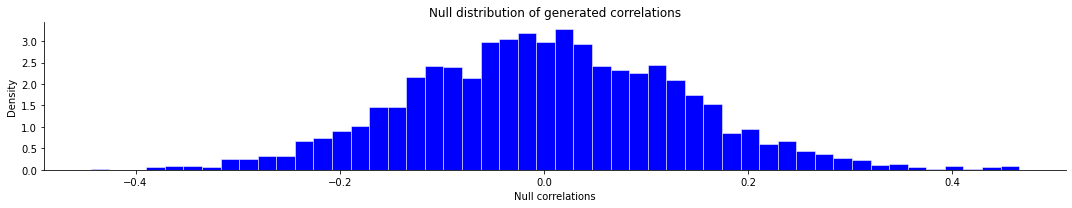

In [34]:
fig, ax = plt.subplots(1, figsize=(15, 3))

ax.hist(spin_test_d, bins=50, density=True, color="blue", edgecolor='white', lw=0.5)
ax.set_xlabel('Null correlations')
ax.set_ylabel('Density')
ax.set_title('Null distribution of generated correlations')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

    
fig.tight_layout()
plt.show()

TO DO:rvals below (original code)?
also add title

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 3))

for k, (fn, dd) in enumerate(p_and_d.items()):
    # Define plot colors
    if k <= 1:
        col = '#A8221C'     # red for functional hubs
    else:
        col = '#324F7D'     # blue for structural hubs

    # Plot null distributions
    axs[k].hist(dd[1], bins=50, density=True, color=col, edgecolor='white', lw=0.5)
    axs[k].axvline(rvals[fn], lw=1.5, ls='--', color='k', dashes=(2, 3),
                   label='$r$={:.2f}'.format(rvals[fn]) + '\n$p$={:.3f}'.format(dd[0]))
    axs[k].set_xlabel('Null correlations \n ({})'.format(fn))
    axs[k].set_ylabel('Density')
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['right'].set_visible(False)
    axs[k].legend(loc=1, frameon=False)

fig.tight_layout()
plt.show()

#### Comparing parcels showing statistically significant sex differences between datasets

In [15]:
def plot_sig_overlap(q_vals_sig_overlap, GSP_v_HCP_sig):
    
    '''
    Function that displays the overlap of signficant sex differences, where:
        - overlap of significant sex differences: 2 (dark green): significant in both samples, 1 (light green): significant in one sample, 0: not significant
        - which dataset shows significant sex difference: +1 (purple) = GSP, -1 (brown) = HCP, 0 (white) = both datasets, nan (grey) = not significant in any dataset
    
    Input required: q values list with 2s, 1s, 0s, GSP vs HCP list with +1, 0, -1
    
    Specific to plotting on surf_lh, surf_rh from conte69; for data coming from Schaefer 400 parcellation
    
    '''
    
    # defining labeling scheme and mask
    # ! if doesn't work anymore for some reason, take this out of the definition (put it before it) !
    labeling = load_parcellation('schaefer', scale=400, join=True)
    surf_lh, surf_rh = load_conte69()
    mask = labeling != 0
    
    # to be displayed
    handles = []
    
    ### sig q vals correspondance
    q_vals_sig_mapped_to_labels = map_to_labels(np.array(q_vals_sig_overlap), labeling, mask=mask, fill=np.nan) 
    
    q_vals_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = q_vals_sig_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = 'Greens', 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        #label_text = ["overlap of significant sex differences"],
        zoom = 1.45)
    
    # append to what will be displayed
    handles.append('Overlap of significant sex differences: 2 (dark green): significant in both samples, 1 (light green): significant in one sample, 0: not significant')  # title
    handles.append(q_vals_plotted_hemispheres)  # plot

    
    ### GSP or HCP significance
    GSP_v_HCP_sig_mapped_to_labels = map_to_labels(np.array(GSP_v_HCP_sig), labeling, mask=mask, fill=np.nan) 
    
    GSP_v_HCP_sig_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = GSP_v_HCP_sig_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = 'PuOr', 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        #label_text = ["overlap of significant sex differences"],
        zoom = 1.45)
    
    # append to what will be displayed
    handles.append('Which dataset shows significant sex difference: +1 (purple) = GSP, -1 (brown) = HCP, 0 (white) = both datasets, nan (grey) = not significant in any dataset')  # title
    handles.append(GSP_v_HCP_sig_plotted_hemispheres)  # plot
        
                                           
    return handles

In [16]:
q_vals_sig_overlap = []  # significant sex differences (per parcel): 2 = in both datasets, 1 = in one dataset only, 0 = not significant in any dataset
GSP_v_HCP_sig = []  # which dataset shows significant sex difference (per parcel): +1 = GSP, -1 = HCP, 0 = both datasets, nan = not significant in any dataset

for i in range (len(GSP_slm_G2.q_val_sex)):
    
    count_sig = 0
    gsp_v_hcp = 0
    not_sig_at_all = True
    
    if GSP_slm_G2.q_val_sex[i] <= 0.05:
        count_sig += 1
        gsp_v_hcp += 1
        not_sig_at_all = False
    
    if HCP_slm_G1.q_val_sex[i] <= 0.05:
        count_sig += 1
        gsp_v_hcp -= 1
        not_sig_at_all = False
    
    if not_sig_at_all:
        q_vals_sig_overlap.append(float(count_sig))  # if no significant we want to save as 0
        GSP_v_HCP_sig.append(float('nan'))  # if no significant we want to save as nan (will be grey in plot hemispheres display)
        
    else:
        q_vals_sig_overlap.append(float(count_sig))
        GSP_v_HCP_sig.append(float(gsp_v_hcp))

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


'Overlap of significant sex differences: 2 (dark green): significant in both samples, 1 (light green): significant in one sample, 0: not significant'

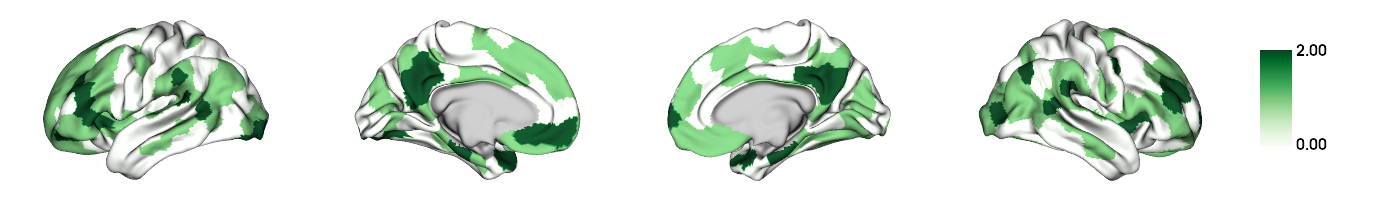

'Which dataset shows significant sex difference: +1 (purple) = GSP, -1 (brown) = HCP, 0 (white) = both datasets, nan (grey) = not significant in any dataset'

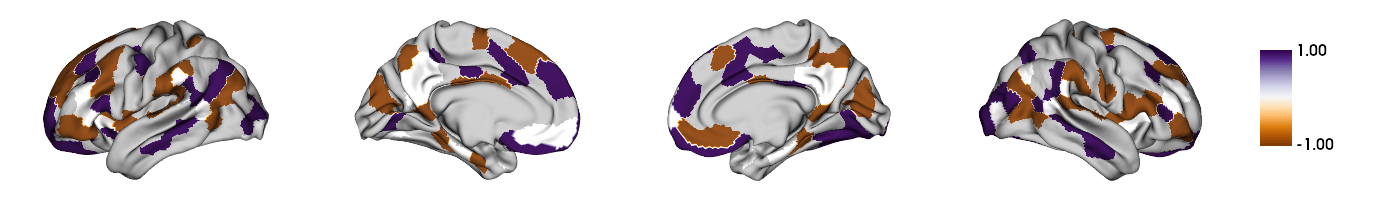

In [17]:
plots_to_display = plot_sig_overlap(q_vals_sig_overlap, GSP_v_HCP_sig)
display(*plots_to_display)

In [18]:
print(f"Number of parcels that show statistically significant sex differences across datasets: {q_vals_sig_overlap.count(2)}")
print(f"Number of parcels that show statistically significant sex differences in GSP only: {GSP_v_HCP_sig.count(1)}")
print(f"Number of parcels that show statistically significant sex differences in HCP only: {GSP_v_HCP_sig.count(-1)}")

Number of parcels that show statistically significant sex differences across datasets: 40
Number of parcels that show statistically significant sex differences in GSP only: 65
Number of parcels that show statistically significant sex differences in HCP only: 83


#### Check whether the directionality of sex differences is the same in the regions that overlap

Number of parcels (out of the 40 parcels that show sig sex differences in both datasets) which show sex differences in opposite directions: 1


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/utils.py:303: RuntimeWarning: All-NaN axis encountered
  a, b = np.nanmin(x), np.nanmax(x)


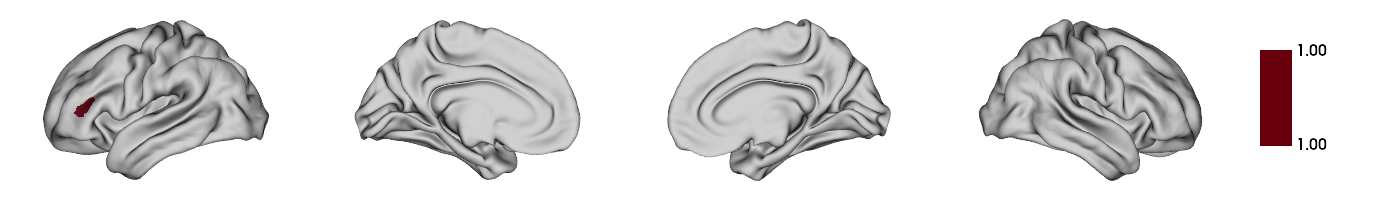

In [19]:
flags = []

for i in range(len(q_vals_sig_overlap)):
    
    if q_vals_sig_overlap[i] == 2:
        
        # if the sign of the t value is the same in GSP and HCP (either (+ and +) or (- and -), then append nan for no problem
        if (GSP_slm_G2.t_val_sex[i] > 0 and HCP_slm_G1.t_val_sex[i] > 0) or (GSP_slm_G2.t_val_sex[i] < 0 and HCP_slm_G1.t_val_sex[i] < 0):
            flags.append(float('nan'))
        
        # else flag the problem with 1
        else:
            flags.append(float(1))
    
    else:
        flags.append(float('nan'))

print(f"Number of parcels (out of the {q_vals_sig_overlap.count(2)} parcels that show sig sex differences in both datasets) which show sex differences in opposite directions: {flags.count(1)}")


## Plot the location of the flagged parcels (if there are any)

if len(flags) > 0:
    
    # defining labeling scheme and mask
    # ! if doesn't work anymore for some reason, take this out of the definition (put it before it) !
    labeling = load_parcellation('schaefer', scale=400, join=True)
    surf_lh, surf_rh = load_conte69()
    mask = labeling != 0


    ### flagged parcels
    flagged_mapped_to_labels = map_to_labels(np.array(flags), labeling, mask=mask, fill=np.nan)  
    
    flagged_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = flagged_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = 'Reds_r', 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        #label_text = ["overlap of significant sex differences"],
        zoom = 1.45)
    
    display(flagged_plotted_hemispheres)
    

#### Visualizing t-values of sex contrast in unimodal-heteromodal gradient by network

RainCloud plots https://github.com/RainCloudPlots/RainCloudPlots#python-environment

RainCloud plot of t-values of sex contrast in unimodal-heteromodal gradient for 7 Yeo networks - by sample

800 data points (400 parcels HCP + 400 parcels GSP)

In [86]:
# dataframe of the t-values 
df_GSP_G2_tval = pd.DataFrame(GSP_slm_G2.t_val_sex)
df_HCP_G1_tval = pd.DataFrame(HCP_slm_G1.t_val_sex)

# adding a column containing the Yeo network labels
df_GSP_G2_tval['yeo network'] = yeo7_networks
df_HCP_G1_tval['yeo network'] = yeo7_networks

# renaming the Yeo network labels
df_GSP_G2_tval.loc[df_GSP_G2_tval["yeo network"] == "1", "yeo network"] = "visual"
df_GSP_G2_tval.loc[df_GSP_G2_tval["yeo network"] == "2", "yeo network"] = "sensory motor"
df_GSP_G2_tval.loc[df_GSP_G2_tval["yeo network"] == "3", "yeo network"] = "dorsal attention"
df_GSP_G2_tval.loc[df_GSP_G2_tval["yeo network"] == "4", "yeo network"] = "ventral attention"
df_GSP_G2_tval.loc[df_GSP_G2_tval["yeo network"] == "5", "yeo network"] = "limbic"
df_GSP_G2_tval.loc[df_GSP_G2_tval["yeo network"] == "6", "yeo network"] = "fronto parietal"
df_GSP_G2_tval.loc[df_GSP_G2_tval["yeo network"] == "7", "yeo network"] = "DMN"

df_HCP_G1_tval.loc[df_HCP_G1_tval["yeo network"] == "1", "yeo network"] = "visual"
df_HCP_G1_tval.loc[df_HCP_G1_tval["yeo network"] == "2", "yeo network"] = "sensory motor"
df_HCP_G1_tval.loc[df_HCP_G1_tval["yeo network"] == "3", "yeo network"] = "dorsal attention"
df_HCP_G1_tval.loc[df_HCP_G1_tval["yeo network"] == "4", "yeo network"] = "ventral attention"
df_HCP_G1_tval.loc[df_HCP_G1_tval["yeo network"] == "5", "yeo network"] = "limbic"
df_HCP_G1_tval.loc[df_HCP_G1_tval["yeo network"] == "6", "yeo network"] = "fronto parietal"
df_HCP_G1_tval.loc[df_HCP_G1_tval["yeo network"] == "7", "yeo network"] = "DMN"


# adding a column containing the label of the respective dataset (for all rows)
df_GSP_G2_tval["sample"] = "GSP"
df_HCP_G1_tval["sample"] = "HCP"

# naming the index and resetting it as an index in order to make it callable in the following melt function
df_GSP_G2_tval.index.name = "parcel"
df_GSP_G2_tval = df_GSP_G2_tval.reset_index()

df_HCP_G1_tval.index.name = "parcel"
df_HCP_G1_tval = df_HCP_G1_tval.reset_index()


# for the RainCloud plots, we need dataframe to have all values to be plotted in 1 column, and labels to be plotted in other columns (max 2)
# concatenate the two datasets (by index in order to have rows = subjects from both datasets) -> already in the correct shape for the Raincloudplot
df_all_tval = pd.concat([df_GSP_G2_tval, df_HCP_G1_tval], axis = 'index')


# WEIRD THAT PALETTE REVERSED FOR NETWORKS (when the labels are the same) -> try to solve

In [125]:
sns.set_palette(reversed(sns.color_palette(n_colors=7)))

TypeError: object of type 'list_reverseiterator' has no len()

In [123]:
sns.color_palette(n_colors=7)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)]

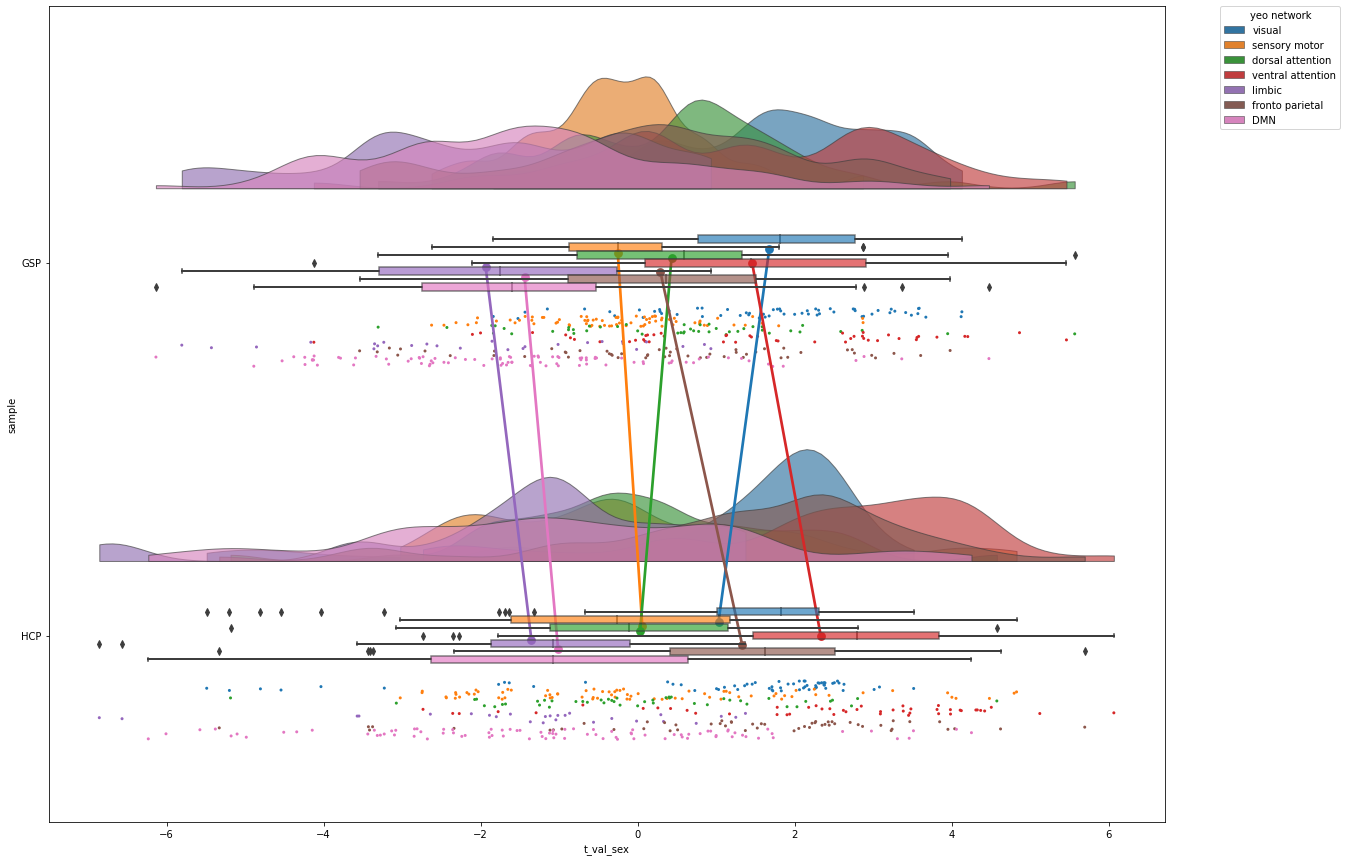

In [122]:
f,ax=plt.subplots(figsize=(20,15))

ax=pt.RainCloud(x="sample",
                y="t_val_sex",
                hue="yeo network",
                data=df_all_tval,
                palette=sns.color_palette(n_colors=7),
                bw=.2,
                width_viol=.6,
                orient="h",
                move=.2,
                alpha=.65,
                pointplot=True, 
                dodge = True)

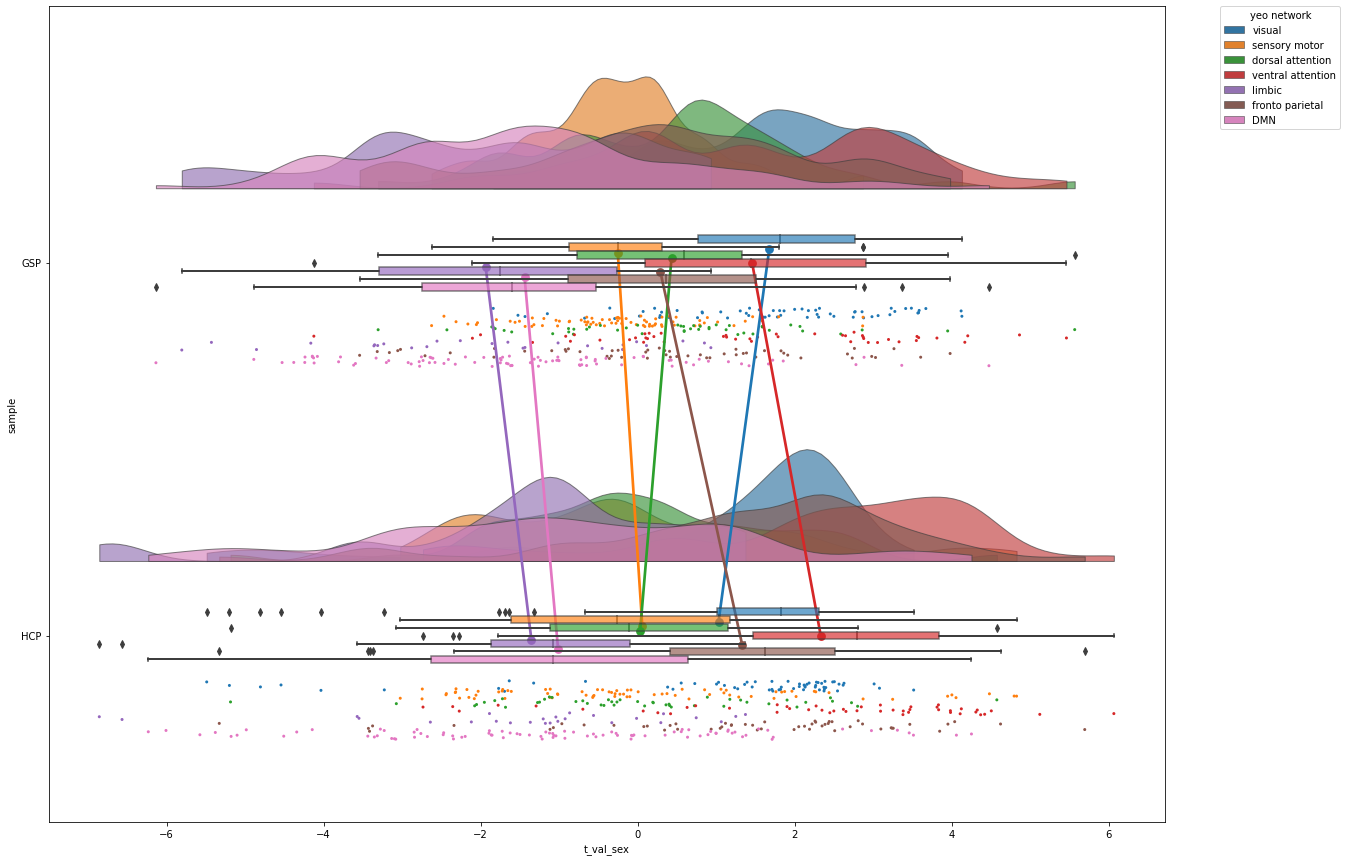

In [87]:
f,ax=plt.subplots(figsize=(20,15))

ax=pt.RainCloud(x="sample",
                y="t_val_sex",
                hue="yeo network",
                data=df_all_tval,
                palette=sns.color_palette(n_colors=7),
                bw=.2,
                width_viol=.6,
                orient="h",
                move=.2,
                alpha=.65,
                pointplot=True, 
                dodge = True)

In [116]:
tvals_sig_pos = []
tvals_sig_neg = []

for i in range(len(GSP_slm_G2)):
    if GSP_slm_G2.iloc[i].q_val_sex < 0.05:
        if GSP_slm_G2.iloc[i].t_val_sex > 0:
            tvals_sig_pos.append(GSP_slm_G2.iloc[i].t_val_sex)
        else:
            tvals_sig_neg.append(GSP_slm_G2.iloc[i].t_val_sex)

print(f"Minimum positive significant t-value in GSP: {round(min(tvals_sig_pos), 2)}\nMinimum negative significant t-value in GSP: {round(max(tvals_sig_neg), 2)}\n")
print(f"Number of positive significant t-values (M > F (gradient eigenvalues)) in GSP: {len(tvals_sig_pos)}\nNumber of negative significant t-values (F > M (gradient eigenvalues)) in GSP: {len(tvals_sig_neg)}\n\n")
      
tvals_sig_pos = []
tvals_sig_neg = []

for i in range(len(HCP_slm_G1)):
    if HCP_slm_G1.iloc[i].q_val_sex < 0.05:
        if HCP_slm_G1.iloc[i].t_val_sex > 0:
            tvals_sig_pos.append(HCP_slm_G1.iloc[i].t_val_sex)
        else:
            tvals_sig_neg.append(HCP_slm_G1.iloc[i].t_val_sex)

print(f"Minimum positive significant t-value in HCP: {round(min(tvals_sig_pos), 2)}\nMinimum negative significant t-value in HCP: {round(max(tvals_sig_neg), 2)}\n")
print(f"Number of positive significant t-values (M > F (gradient eigenvalues)) in HCP: {len(tvals_sig_pos)}\nNumber of negative significant t-values (F > M (gradient eigenvalues)) in HCP: {len(tvals_sig_neg)}")

Minimum positive significant t-value in GSP: 2.5
Minimum negative significant t-value in GSP: -2.56

Number of positive significant t-values (M > F (gradient eigenvalues)) in GSP: 56
Number of negative significant t-values (F > M (gradient eigenvalues)) in GSP: 49


Minimum positive significant t-value in HCP: 2.43
Minimum negative significant t-value in HCP: -2.44

Number of positive significant t-values (M > F (gradient eigenvalues)) in HCP: 75
Number of negative significant t-values (F > M (gradient eigenvalues)) in HCP: 48


# Equal sex samples in GSP

In [7]:
equal_sex_ratio_resdir = '/data/p_02667/sex_diff_gradients/results/GSP/equal_sex_samples/'

## Comparing results between GSP and HCP samples for 3 fc gradients

In [8]:
## loading aligned gradient arrays

# GSP
GSP_array_aligned_G1 = pd.read_csv(equal_sex_ratio_resdir+'array_aligned_G1.csv')  # visual - sensorimotor
GSP_array_aligned_G2 = pd.read_csv(equal_sex_ratio_resdir+'array_aligned_G2.csv')  # unimodal - heteromodal
GSP_array_aligned_G3 = pd.read_csv(equal_sex_ratio_resdir+'array_aligned_G3.csv')  

# HCP
HCP_array_aligned_G1 = pd.read_csv(resdir+'HCP/array_aligned_G1.csv')  # visual - sensorimotor
HCP_array_aligned_G2 = pd.read_csv(resdir+'HCP/array_aligned_G2.csv')  # unimodal - heteromodal
HCP_array_aligned_G3 = pd.read_csv(resdir+'HCP/array_aligned_G3.csv')  


# loading SLM (model including sex, age and ICV for sex testing for sex differences) containing R results

# GSP
GSP_slm_G1 = pd.read_csv(equal_sex_ratio_resdir+'R_lm_G1_sex_age_icv_res.csv')  # visual - sensorimotor
GSP_slm_G2 = pd.read_csv(equal_sex_ratio_resdir+'R_lm_G2_sex_age_icv_res.csv')  # unimodal - heteromodal
GSP_slm_G3 = pd.read_csv(equal_sex_ratio_resdir+'R_lm_G3_sex_age_icv_res.csv')  

# HCP
HCP_slm_G1 = pd.read_csv(resdir+'HCP/R_lm_G1_sex_age_icv_res.csv')  # unimodal - heteromodal
HCP_slm_G2 = pd.read_csv(resdir+'HCP/R_lm_G2_sex_age_icv_res.csv')  # visual - sensorimotor
HCP_slm_G3 = pd.read_csv(resdir+'HCP/R_lm_G3_sex_age_icv_res.csv')  

In [9]:
GSP_array_aligned_G1

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
0,-0.082133,-0.066215,-0.080661,-0.084880,-0.077575,-0.076887,-0.062602,-0.073691,-0.015290,0.031513,...,-0.034469,-0.042364,0.006757,0.003033,-0.054271,-0.048465,-0.041827,-0.035801,-0.053990,0.030903
1,-0.030666,-0.053596,-0.053206,-0.048282,-0.082642,-0.068180,-0.035396,-0.051453,-0.084432,-0.051278,...,-0.056285,-0.063770,-0.081328,-0.066138,-0.067382,-0.057770,-0.069832,-0.061462,-0.058846,-0.065523
2,0.025450,-0.041640,-0.058750,-0.006479,-0.049157,-0.039589,0.012992,-0.055401,-0.027367,-0.045053,...,-0.035814,-0.041784,-0.039154,-0.029441,-0.053875,-0.051686,-0.050557,-0.021388,-0.048990,-0.007238
3,-0.023399,-0.039016,-0.019835,-0.075459,-0.077863,-0.056568,-0.013849,0.004952,0.025241,-0.074234,...,-0.048519,-0.044832,-0.027987,-0.025294,-0.069777,-0.068839,-0.050598,-0.036049,-0.064844,-0.041328
4,-0.021171,-0.039445,-0.046569,-0.007720,-0.053457,-0.066678,-0.039309,-0.036640,-0.066544,-0.031893,...,-0.033827,-0.056558,0.006907,-0.046956,-0.059553,-0.056409,-0.036136,-0.013597,-0.057806,-0.034960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,-0.034382,-0.000525,-0.029649,-0.053437,-0.037133,-0.021655,-0.063021,-0.003066,-0.035849,-0.079835,...,-0.064491,-0.026709,-0.039263,-0.031068,-0.067217,-0.055415,-0.060881,-0.060918,-0.069679,-0.010542
1322,-0.091011,-0.043029,-0.104534,-0.107139,-0.095466,-0.085733,-0.043321,-0.034559,-0.092753,-0.084279,...,-0.034066,-0.043631,0.034397,-0.039198,-0.052868,-0.047531,-0.043022,-0.029188,-0.055379,-0.015599
1323,-0.006767,-0.043651,-0.057953,-0.083764,-0.084100,-0.051119,-0.020918,-0.056951,-0.075899,-0.071424,...,-0.045363,-0.055555,-0.060081,-0.078738,-0.054219,-0.047135,-0.052711,-0.031493,-0.052081,-0.002395
1324,-0.032658,-0.067270,-0.063337,-0.054821,-0.048409,-0.024242,-0.062289,-0.034921,-0.027933,-0.048040,...,-0.042740,-0.041016,-0.004929,-0.025418,-0.030720,-0.036519,-0.058757,-0.044947,-0.052560,-0.028018


In [10]:
stats.pearsonr(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)

(0.5496274251492854, 5.959788882671919e-33)

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'HCP G1')

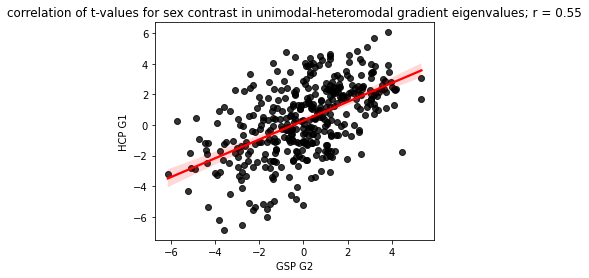

In [11]:
fig, ax = plt.subplots(1, figsize=(5, 4))

sns.regplot(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex,
            scatter_kws={"color": "black"}, line_kws={"color": "red"})

ax.set_title(f'correlation of t-values for sex contrast in unimodal-heteromodal gradient eigenvalues; r = {round(stats.pearsonr(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)[0],2)}')
ax.set_xlabel('GSP G2')
ax.set_ylabel('HCP G1')


### Spin permutation test

https://enigma-toolbox.readthedocs.io/en/latest/pages/08.spintest/index.html

#### Project t-values (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices

In [12]:
# fetch the fsaverage parcellation indicating which schafer parcel (1-400) each of fsaverage5's 20484 vertices belong to
schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400)

In [13]:
GSP_fs5_tvals_sexdif_G2 = []
HCP_fs5_tvals_sexdif_G1 = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    #if schaefer_400_fs5[i] == 'nan'
    if schaefer_400_fs5[i] == 0:
        # append to the lists of fs5_tvals: 0
        GSP_fs5_tvals_sexdif_G2.append(0)
        HCP_fs5_tvals_sexdif_G1.append(0)
        
    # if schaefer_400_fs5 has a value
    else:
        # append to the lists of fs5_tvals: the t value of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing t_val_sex)
        GSP_fs5_tvals_sexdif_G2.append(GSP_slm_G2.t_val_sex[schaefer_400_fs5[i]-1])
        HCP_fs5_tvals_sexdif_G1.append(HCP_slm_G1.t_val_sex[schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
GSP_fs5_tvals_sexdif_G2[GSP_fs5_tvals_sexdif_G2 == 0] = np.nan
HCP_fs5_tvals_sexdif_G1[HCP_fs5_tvals_sexdif_G1 == 0] = np.nan

# transform list into array
GSP_fs5_tvals_sexdif_G2 = np.asarray(GSP_fs5_tvals_sexdif_G2)
HCP_fs5_tvals_sexdif_G1 = np.asarray(HCP_fs5_tvals_sexdif_G1)

# PROBLEM
values go from 0-400, so there are 401 'categories' -> I assume this means that 0 is a non-category and schaefer parcel labels go from 1-400

!!!!! NEED TO CHECK WHAT THIS NON CATEGORY IS... SEEMS LIKE THERE IS AN ISSUE HERE (I thought it would mean "outside the grid" but I don't think fsaverage is a grid... maybe it's an areas like midline or ventricles which is missing in Schaefer 400)


In [14]:
min(schaefer_400_fs5)

0

In [15]:
max(schaefer_400_fs5)

400

In [16]:
# Spin permutation testing for two cortical maps (output of spin_test is the p-value and the null distribution)
spin_test_p, spin_test_d = spin_test(GSP_fs5_tvals_sexdif_G2, HCP_fs5_tvals_sexdif_G1, surface_name='fsa5', parcellation_name='aparc', type='pearson', n_rot=1000, null_dist=True)statistically

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


In [17]:
spin_test_p

0.0

In [18]:
spin_test_d

array([ 0.0613521 ,  0.19096881,  0.11052274, ...,  0.01444785,
       -0.13502071,  0.02716053])

To better interpret statistical significance, we can plot the null distribution of generated correlations (i.e., “spun” or “shuffled” correlations) and overlay the correlation coefficient obtained from the empirical (i.e., real) brain maps.

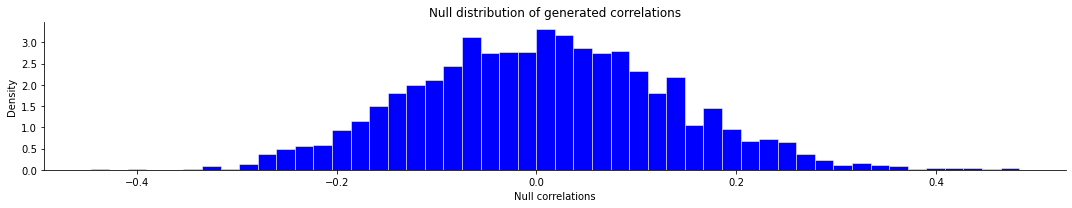

In [19]:
fig, ax = plt.subplots(1, figsize=(15, 3))

ax.hist(spin_test_d, bins=50, density=True, color="blue", edgecolor='white', lw=0.5)
ax.set_xlabel('Null correlations')
ax.set_ylabel('Density')
ax.set_title('Null distribution of generated correlations')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

    
fig.tight_layout()
plt.show()

# old to delete (changing to nan)

In [42]:
GSP_fs5_tvals_sexdif_G2 = []
HCP_fs5_tvals_sexdif_G1 = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    #if schaefer_400_fs5[i] == 'nan'
    if isnan(schaefer_400_fs5[i]):
        # append to the lists of fs5_tvals: 0
        GSP_fs5_tvals_sexdif_G2.append(0)
        HCP_fs5_tvals_sexdif_G1.append(0)
        
    # if schaefer_400_fs5 has a value
    else:
        # append to the lists of fs5_tvals: the t value of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing t_val_sex)
        GSP_fs5_tvals_sexdif_G2.append(GSP_slm_G2.t_val_sex[schaefer_400_fs5[i]-1])
        HCP_fs5_tvals_sexdif_G1.append(HCP_slm_G1.t_val_sex[schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
GSP_fs5_tvals_sexdif_G2[GSP_fs5_tvals_sexdif_G2 == 0] = np.nan
HCP_fs5_tvals_sexdif_G1[HCP_fs5_tvals_sexdif_G1 == 0] = np.nan

# transform list into array
GSP_fs5_tvals_sexdif_G2 = np.asarray(GSP_fs5_tvals_sexdif_G2)
HCP_fs5_tvals_sexdif_G1 = np.asarray(HCP_fs5_tvals_sexdif_G1)